In [107]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
from skimage import feature, exposure
from sklearn import cluster
from patchify import patchify

In [108]:
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            scaled = cv2.resize(img, (256, 256))
            images.append(scaled)
    return images

### Search image

In [109]:
imgs = load_images('../../inputs/dd/')

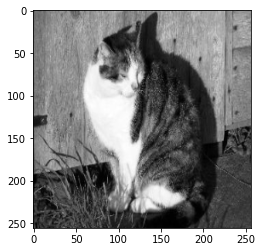

In [110]:
img = cv2.imread('../../inputs/15_19_s.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (256, 256))
# pyplot uses rgb so image is reversed before displaying
plt.imshow(img, cmap='gray')

### Computing HOG descriptors

In [111]:
patches = patchify(img, (16, 16), step=16)

In [112]:
patches.shape

(16, 16, 16, 16)

In [113]:
fds = []
for p_row in patches:
    for patch in p_row:
        fd, hog_img = feature.hog(patch, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                    visualize=True, multichannel=False)
        fds.append(fd)
fds = np.array(fds)

In [114]:
fds.shape

(256, 36)

In [115]:
descriptors = []

for image in imgs:
    patches = patchify(np.array(image), (16, 16), step=16)
    pdesc = []
    for p_row in patches:
        for patch in p_row:
            fd, hog_img = feature.hog(patch, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                    visualize=True, multichannel=False)
            pdesc.append(fd)
    descriptors.append(pdesc)

descs = np.array(descriptors)
descs = np.float32(descs)

In [116]:
descs.shape

(50, 256, 36)

In [117]:
# k is number of words in vocab, ie, number of clusters formed
k = 5
vocab = []

for i in range(256):
    bow = cv2.BOWKMeansTrainer(k)
    centers = bow.cluster(descs[:,i,:])
    vocab.append(centers)

vocab = np.array(vocab)

In [118]:
vocab.shape

(256, 5, 36)

In [119]:
fds.shape

(256, 36)

### Creating feature for input image

In [120]:
def make_histo(vocab, feature):
    histo = np.zeros(k)
    for i in range(len(feature)):
        idx = findmin(vocab[i], feature[i])
        histo[idx] += 1
    return histo.astype(int)

def findmin(centers, pfeature):
    idx = -1
    mindist = np.inf
    for i in range(len(centers)):
        dist = np.sum((centers[i] - pfeature)**2)
        if(dist < mindist):
            mindist = dist
            idx = i
    return idx

In [121]:
output = make_histo(vocab, fds)
output

array([58, 54, 51, 51, 42])